### 전체 사진을 일괄 본인이 Labeling 하는 경우 시간이
### 너무 오래걸리기 때문에, 사전 학습된 모델을 사용하여
### 1차 Label File을 만들고, 이를 눈으로 확인하며 수정하는 것이 시간을 절약할 수 있음

### 단, 여기서 모든 File을 Label Target 으로 설정하는 것이 아니라, 일정 Percentage (ex : 0.5) 이상의 파일인 경우에만
### Label을 할 수 있도록 그 이하인 경우 따로 추후 확인해볼 수 있도록 함.

In [1]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [2]:
# Check with exported model and if it is well trained
# these codes are from inference_from_saved_model_tf2_colab.ipynb

import io
import os
import scipy.misc
import numpy as np
import six
import time

from six import BytesIO

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import label_map_util

%matplotlib inline

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
#   print(im_width, im_height)
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)



In [3]:
# Path to label map file
PATH_TO_LABELS = os.path.join('/home001/yousung.choi/projects/project_coordination/workspace/training_demo/annotations','label_map.pbtxt')

# Number of classes the object detector can identify
NUM_CLASSES = 1

# Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# 1: {'id': 1, 'name': 'book'},
print(category_index)

{1: {'id': 1, 'name': 'Cursor'}}


In [4]:
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load('/home001/yousung.choi/projects/project_coordination/workspace/training_demo/exported-models/3rd_trial_210323/saved_model')
# detect_fn = tf.saved_model.load('/home001/yousung.choi/projects/project_coordination/workspace/training_demo/exported-models/1st_trial/saved_model')
# detect_fn = tf.saved_model.load('/home/yousungchoi/projects/project_coordination/workspace/training_demo/exported-models/2nd_tria_320320/saved_model')
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 8.666785717010498s


In [5]:
# print(detect_fn.signatures['serving_default'].inputs)
# print(detect_fn.signatures['serving_default'].inputs)
print(detect_fn.signatures['serving_default'].output_dtypes)
# print(detect_fn.signatures['serving_default'].output_shapes)

{'raw_detection_boxes': tf.float32, 'num_detections': tf.float32, 'raw_detection_scores': tf.float32, 'detection_anchor_indices': tf.float32, 'detection_classes': tf.float32, 'detection_multiclass_scores': tf.float32, 'detection_boxes': tf.float32, 'detection_scores': tf.float32}


In [6]:
import os
import numpy as np
import cv2
import xml.etree.ElementTree as ET
from tqdm import tqdm
import sys
import math
import random
import shutil

# we are only going to 1 max score point to be labeled here.

def inference_and_record(img_file):
    image_path = img_file
    image_cv2 = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image_np = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
    input_tensor = np.expand_dims(image_np, 0)
    
    detections = detect_fn(input_tensor)
    
    return detections

    
    
    

In [7]:
target_folder = '/home001/yousung.choi/projects/project_coordination/tools/1_datasets/2_video_to_imgs/Rainbow_Test/13_Qmemo_typing_and_drawing/'
files = os.listdir(target_folder)
files.sort()
print(files[:5])

['images13000.jpg', 'images13001.jpg', 'images13002.jpg', 'images13003.jpg', 'images13004.jpg']


In [9]:
if not os.path.exists(target_folder + 'valid'):
    os.mkdir(target_folder + 'valid')

if not os.path.exists(target_folder + 'invalid'):
    os.mkdir(target_folder + 'invalid')
    

for i, file in enumerate(tqdm(files)):
    detects = inference_and_record(target_folder + file)
    value = (detects['detection_scores'][0] > 0.5).numpy()
    
    if np.count_nonzero(value == True) > 0:
        shutil.copy(target_folder + file, target_folder + 'valid/' + file)
    else:
        shutil.copy(target_folder + file, target_folder + 'invalid/' + file)      
        

100%|██████████| 817/817 [02:28<00:00,  5.51it/s]


#### 특정 폴더의 사진을 Iteration 하면서 추론한 뒤 XML 파일로 Write 함.
#### 모든 XML 내용을 다 써붙이는 것은 코드상 불필요하므로, Labelimg 를 이용해 생성된 첫 파일의 XML 내용을 기준으로, Coordination 과 File명만 변경해주는 방식을 사용

In [10]:
import os
import numpy as np
import cv2
import xml.etree.ElementTree as ET
from tqdm import tqdm
import sys
import math
import random
import shutil

img_dir = '/home001/yousung.choi/projects/project_coordination/tools/1_datasets/2_video_to_imgs/Rainbow_Test/13_Qmemo_typing_and_drawing/valid/'
all_files = os.listdir(img_dir)
all_files.sort()

# 1) preprocessing files into list
img_files = []
xml_files = []
skip_files = []
for i, file in enumerate(all_files):
    if file.endswith('jpg'):
        img_files.append(img_dir + file)
    elif file.endswith('xml'):
        xml_files.append(img_dir + file)

# 2) read first xml file to be targeted.
base_xml = open(xml_files[0], 'rt', encoding='UTF8')
tree = ET.parse(base_xml)
root = tree.getroot()

filename_tag = root.find('filename')
width_tag = root.find('size').find('width')
height_tag = root.find('size').find('height')
xmin_tag = root.find('object').find('bndbox').find('xmin')
ymin_tag = root.find('object').find("bndbox").find("ymin")
xmax_tag = root.find('object').find("bndbox").find("xmax")
ymax_tag = root.find('object').find("bndbox").find("ymax")

# print(filename_tag.text)
# print(width_tag.text)
# print(height_tag.text)
# print(xmin_tag.text)
# print(ymin_tag.text)
# print(xmax_tag.text)
# print(ymax_tag.text)  

# 3) write all other jpg xml files
for i, img_file in enumerate(tqdm(img_files)):
    if i == 0:
        continue
    else:
        file_name = img_file.split('/')[-1].split('.')[0]
        filename_tag.text = str(file_name + '.jpg')
        
        image_path = img_file
        image_cv2 = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image_np = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
        input_tensor = np.expand_dims(image_np, 0)

        detections = detect_fn(input_tensor)
        
        ymin, xmin, ymax, xmax = 0,0,0,0
        if (detections['detection_scores'][0][0] > 0.6):
            ymin = detections['detection_boxes'][0][0][0] * image_np.shape[0]
            xmin = detections['detection_boxes'][0][0][1] * image_np.shape[1]
            ymax = detections['detection_boxes'][0][0][2] * image_np.shape[0]
            xmax = detections['detection_boxes'][0][0][3] * image_np.shape[1]
            
            xmin_tag.text = str(int(math.ceil(xmin)))
            ymin_tag.text = str(int(math.ceil(ymin)))
            xmax_tag.text = str(int(math.ceil(xmax)))
            ymax_tag.text = str(int(math.ceil(ymax)))
        else:
            skip_files.append(file_name + '.xml')
        
        edit_xml_file = img_dir + file_name + '.xml'
        tree.write(edit_xml_file)
#         print(edit_xml_file)
    

100%|██████████| 270/270 [00:48<00:00,  5.58it/s]


In [11]:
for val in skip_files:
    print(val)
print(skip_files)

images13344.xml
images13527.xml
['images13344.xml', 'images13527.xml']


In [36]:
# Test session 1
detections.keys()

dict_keys(['raw_detection_boxes', 'detection_classes', 'detection_anchor_indices', 'num_detections', 'detection_scores', 'raw_detection_scores', 'detection_boxes', 'detection_multiclass_scores'])

In [44]:
# Test session 2
print(image_np.shape)
print(detections['detection_scores'])
print(detections['detection_boxes'][0])

(1600, 720, 3)
tf.Tensor([[0.12151244 0.05935442 0.0489465  0.04304039 0.03473073]], shape=(1, 5), dtype=float32)
tf.Tensor(
[[0.60498136 0.38624725 0.63374203 0.4503115 ]
 [0.6048408  0.31298903 0.6328849  0.37717304]
 [0.00191585 0.16987067 0.00384379 0.24292275]
 [0.         0.9804287  0.01528279 0.9956051 ]
 [0.00140287 0.94298404 0.00431807 1.        ]], shape=(5, 4), dtype=float32)


tf.Tensor([0.12151244 0.05935442 0.0489465  0.04304039 0.03473073], shape=(5,), dtype=float32)
tf.Tensor(967.97015, shape=(), dtype=float32) tf.Tensor(278.09802, shape=(), dtype=float32) tf.Tensor(1013.98724, shape=(), dtype=float32) tf.Tensor(324.22427, shape=(), dtype=float32)


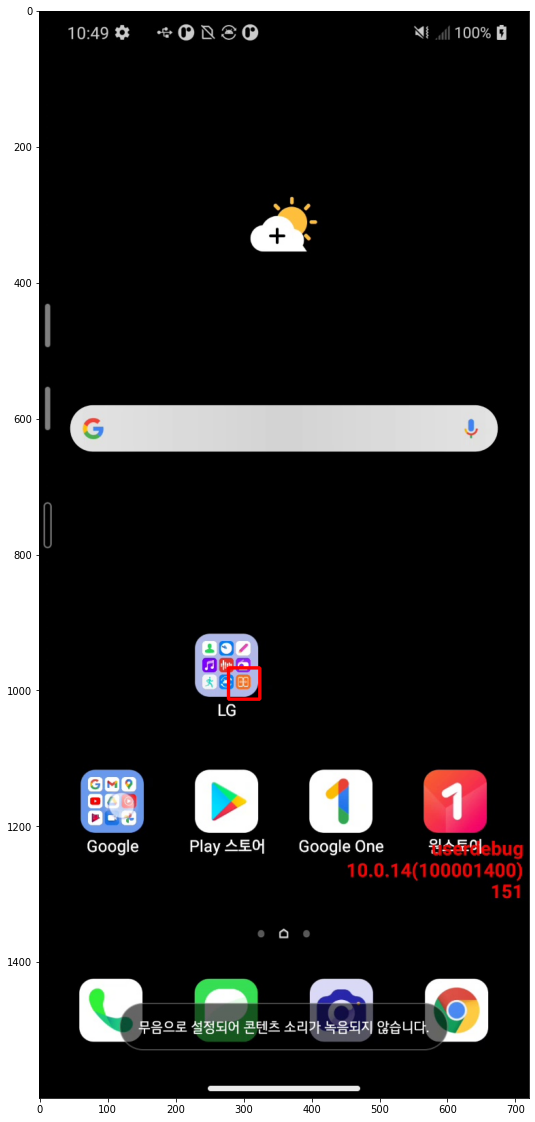

In [54]:
# Test session 3
plt.rcParams['figure.figsize'] = [20, 20]
temp_image = image_np.copy()

print(detections['detection_scores'][0])
ymin = detections['detection_boxes'][0][0][0] * image_np.shape[0]
xmin = detections['detection_boxes'][0][0][1] * image_np.shape[1]
ymax = detections['detection_boxes'][0][0][2] * image_np.shape[0]
xmax = detections['detection_boxes'][0][0][3] * image_np.shape[1]

cv2.rectangle(temp_image,(xmin, ymin), (xmax, ymax), (255, 0, 0), 3)
plt.imshow(temp_image)

In [53]:
a, b, c, d = 0, 0, 0, 0dd